In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch_optimizer as optim  # 提供 Ranger 优化器
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from coordatt import CoordAtt

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 超参数
batch_size = 128
lr = 1e-3
num_epochs = 70
model_name = 'resnet50'  # 可选：'simplecnn' 或 'resnet50'

# --- Setup MPS device ---
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [3]:
# 数据集根目录
root_dir = 'data/iCubWorld'
train_dir = 'data/iCubWorld/train'


In [4]:
def get_mean_std(train_dir):
    # 1. 定义只做 ToTensor 的 transform（将像素从 [0,255] 归一到 [0,1]）
    to_tensor = transforms.ToTensor()

    # 2. 用 ImageFolder 加载训练集（不做任何裁剪／增强）
    dataset = torchvision.datasets.ImageFolder(train_dir, transform=to_tensor)

    # 3. 构造 DataLoader，顺序读取所有样本
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,      # 不打乱，顺序也没关系
        num_workers=4
    )

    # 4. 累加器：记录所有像素的总和与平方和，以及总像素数
    sum_rgb     = torch.zeros(3)  # 各通道所有像素之和
    sum_sq_rgb  = torch.zeros(3)  # 各通道所有像素平方之和
    total_pixels = 0              # 所有图片的像素总数（batch * H * W）

    # 5. 遍历 DataLoader，累加求和
    for imgs, _ in loader:
        # imgs: Tensor of shape (B, 3, H, W), 值在 [0,1]
        b, c, h, w = imgs.shape

        # 累加像素值
        # 对 (B,3,H,W) 张量按 dim=[0,2,3] 求和，得到 (3,) 向量
        sum_rgb    += imgs.sum(dim=[0, 2, 3])
        sum_sq_rgb += (imgs ** 2).sum(dim=[0, 2, 3])

        # 累加像素总数
        total_pixels += b * h * w

    # 6. 计算均值与标准差
    # mean = E[x]
    mean = sum_rgb / total_pixels
    # std  = sqrt(E[x^2] - (E[x])^2)
    std  = (sum_sq_rgb / total_pixels - mean ** 2).sqrt()

    return mean, std


mean, std = get_mean_std(train_dir)
print('Dataset mean:', mean.tolist())
print('Dataset std :', std.tolist())

Dataset mean: [0.4298136234283447, 0.39438438415527344, 0.36725589632987976]
Dataset std : [0.22690562903881073, 0.20988260209560394, 0.19859203696250916]


In [5]:
# # 1. 定义只做 ToTensor 的 transform（将像素从 [0,255] 归一到 [0,1]）
# to_tensor = transforms.ToTensor()

# # 2. 用 ImageFolder 加载训练集（不做任何裁剪／增强）
# train_dir = 'data/iCubWorld/train'
# dataset = torchvision.datasets.ImageFolder(train_dir, transform=to_tensor)

# # 3. 构造 DataLoader，顺序读取所有样本
# loader = DataLoader(
#     dataset,
#     batch_size=64,
#     shuffle=False,      # 不打乱，顺序也没关系
#     num_workers=4
# )

# # 4. 累加器：记录所有像素的总和与平方和，以及总像素数
# sum_rgb     = torch.zeros(3)  # 各通道所有像素之和
# sum_sq_rgb  = torch.zeros(3)  # 各通道所有像素平方之和
# total_pixels = 0              # 所有图片的像素总数（batch * H * W）

# # 5. 遍历 DataLoader，累加求和
# for imgs, _ in loader:
#     # imgs: Tensor of shape (B, 3, H, W), 值在 [0,1]
#     b, c, h, w = imgs.shape

#     # 累加像素值
#     # 对 (B,3,H,W) 张量按 dim=[0,2,3] 求和，得到 (3,) 向量
#     sum_rgb    += imgs.sum(dim=[0, 2, 3])
#     sum_sq_rgb += (imgs ** 2).sum(dim=[0, 2, 3])

#     # 累加像素总数
#     total_pixels += b * h * w

# # 6. 计算均值与标准差
# # mean = E[x]
# mean = sum_rgb / total_pixels
# # std  = sqrt(E[x^2] - (E[x])^2)
# std  = (sum_sq_rgb / total_pixels - mean ** 2).sqrt()

# print('Dataset mean:', mean.tolist())
# print('Dataset std :', std.tolist())

In [6]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None, ca_reduction=32):
        super().__init__()
        # 1×1 降维
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        # 3×3 空洞感受野
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        # 1×1 恢复维度
        self.conv3 = nn.Conv2d(planes, planes * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(planes * self.expansion)

        # **CoordAtt 模块**
        self.ca    = CoordAtt(planes * self.expansion,
                              planes * self.expansion,
                              reduction=ca_reduction)
        # 如果跨步或通道数变化，用下采样调整捷径
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))


        # 在 addition 之前做 Coordinate Attention
        out = self.ca(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class SimpleResNetLike(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # 初始层（可以改成 3×3 conv + BN + ReLU，去掉大核7×7）
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        # 四个 stage，block 数量可按 ResNet-50 ([3,4,6,3]) 或简化
        self.layer1 = self.make_layer( 64,  64, blocks=3, stride=1)  # 输出 256 通道
        self.layer2 = self.make_layer(256, 128, blocks=4, stride=2)  # 输出 512 通道
        self.layer3 = self.make_layer(512, 256, blocks=6, stride=2)  # 输出1024 通道
        self.layer4 = self.make_layer(1024,512, blocks=3, stride=2)  # 输出2048 通道

        # 全局池化 + 全连接
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

        self._init_weights()

    def make_layer(self, in_planes, planes, blocks, stride=1):
        downsample = None
        out_planes = planes * Bottleneck.expansion
        if stride != 1 or in_planes != out_planes:
            # 用 1×1 卷积来匹配维度 & 跨步下采样
            downsample = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                        kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes),
            )
        layers = [Bottleneck(in_planes, planes, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(Bottleneck(out_planes, planes))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He 初始化
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                # 全连接层也可以做类似初始化
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='linear')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                # BN 的 weight 初始化为 1，bias 为 0
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [7]:
# 可选模型：SimpleCNN 或 ResNet50
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


def get_model(name='resnet50', num_classes=10):
    if name.lower() == 'resnet50':
        model = torchvision.models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        model = SimpleResNetLike(num_classes)
    return model







In [8]:
def train_epoch(model, device, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)


def evaluate(model, device, loader, criterion):
    model.eval()
    correct, total_loss = 0, 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)
    

In [9]:
def split_train_val_index(full_train, train_ratio=0.8):
    train_indices, val_indices = random_split(
        list(range(len(full_train))),
        [int(len(full_train) * train_ratio), len(full_train) - int(len(full_train) * train_ratio)]
    )
    return train_indices, val_indices

In [10]:
def get_data_augmentation(train_indices, val_indices):
    # 数据增强与标准化
    transform_train = transforms.Compose([
    # —— PIL Image 处理 ——  
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomVerticalFlip(),

    # —— 转 Tensor 并归一化到 [0,1] ——  
    transforms.ToTensor(),

    # —— Tensor-only 操作 ——  
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize(mean, std),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),        # 或 Resize((256,256))
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = Subset(
        torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'), transform=transform_train),
        train_indices.indices if hasattr(train_indices, 'indices') else train_indices
    )
    val_set = Subset(
        torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'), transform=transform_train),
        val_indices.indices if hasattr(val_indices, 'indices') else val_indices
    )

    test_bg = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/background'), transform=transform_test)
    test_cat = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/categorization'), transform=transform_test)
    test_demo = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/demonstrator'), transform=transform_test)
    test_robot = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'test/robot'), transform=transform_test)
    # test_bg = torchvision.datasets.ImageFolder('data/iCubWorld/test/background', transform_test)
    # test_cat = torchvision.datasets.ImageFolder('data/iCubWorld/test/categorization', transform_test)
    # test_demo = torchvision.datasets.ImageFolder('data/iCubWorld/test/demonstrator', transform_test)
    # test_robot = torchvision.datasets.ImageFolder('data/iCubWorld/test/robot', transform_test)
    
    return train_set, val_set, test_bg, test_cat, test_demo, test_robot

In [11]:
# 加载iCubWorld 1.0训练集并拆分为 train/val
full_train = torchvision.datasets.ImageFolder(os.path.join(root_dir, 'train'),transform=None)
# test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

train_indices, val_indices = split_train_val_index(full_train, train_ratio=0.8)

# get train/val/test sets after data pre-processing and augmentation
train_set, val_set, test_bg, test_cat, test_demo, test_robot = get_data_augmentation(train_indices, val_indices)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

test_bg_loader = DataLoader(test_bg, batch_size=batch_size, shuffle=False, num_workers=4)
test_cat_loader = DataLoader(test_cat, batch_size=batch_size, shuffle=False, num_workers=4)
test_demo_loader = DataLoader(test_demo, batch_size=batch_size, shuffle=False, num_workers=4)
test_robot_loader = DataLoader(test_robot, batch_size=batch_size, shuffle=False, num_workers=4)

test_loaders = {
    'background': test_bg_loader,
    'categorization': test_cat_loader,
    'demonstrator': test_demo_loader,
    'robot': test_robot_loader
}

In [12]:
full_train.class_to_idx

for i in range(1):
    print(f'train_set[{i}]:', train_set[i])
    

train_set[0]: (tensor([[[-1.8942, -1.8942, -1.8942,  ..., -1.8942, -1.8942, -1.8942],
         [-1.8942, -1.8942, -1.8942,  ..., -1.8942, -1.8942, -1.8942],
         [-1.8942, -1.8942, -1.8942,  ..., -1.8942, -1.8942, -1.8942],
         ...,
         [-1.8942, -1.8942, -1.8942,  ..., -1.8942, -1.8942, -1.8942],
         [-1.8942, -1.8942, -1.8942,  ..., -1.8942, -1.8942, -1.8942],
         [-1.8942, -1.8942, -1.8942,  ..., -1.8942, -1.8942, -1.8942]],

        [[-1.8791, -1.8791, -1.8791,  ..., -1.8791, -1.8791, -1.8791],
         [-1.8791, -1.8791, -1.8791,  ..., -1.8791, -1.8791, -1.8791],
         [-1.8791, -1.8791, -1.8791,  ..., -1.8791, -1.8791, -1.8791],
         ...,
         [-1.8791, -1.8791, -1.8791,  ..., -1.8791, -1.8791, -1.8791],
         [-1.8791, -1.8791, -1.8791,  ..., -1.8791, -1.8791, -1.8791],
         [-1.8791, -1.8791, -1.8791,  ..., -1.8791, -1.8791, -1.8791]],

        [[-1.8493, -1.8493, -1.8493,  ..., -1.8493, -1.8493, -1.8493],
         [-1.8493, -1.8493, -1

In [13]:


# 模型、损失、优化器
model = get_model("SimpleResNetLike").to(device)

# Use ResNet50 as the model
num_classes = 10
# model = torchvision.models.resnet50(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# model = SimpleCNN(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Ranger(
    model.parameters(),
    lr=1e-3,
    betas=(0.95, 0.999),
    eps=1e-6,
    weight_decay=0,
    alpha=0.5,
    k=6
)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=num_epochs * len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

# get the information of the optimizer
print(optimizer)

# 训练与验证
train_losses, val_losses, val_accs = [], [], []

best_val_acc = 0.0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")
    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './model/best_model_cnn_icubr.pth')





Ranger (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    base_momentum: 0.85
    betas: (0.95, 0.999)
    eps: 1e-06
    initial_lr: 4e-05
    k: 6
    lr: 3.9999999999999996e-05
    max_lr: 0.001
    max_momentum: 0.95
    min_lr: 4e-09
    step_counter: 0
    weight_decay: 0
)


/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1581.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch 00 | Train Loss: 2.4020 | Val Loss: 2.3487 | Val Acc: 9.99%
Epoch 01 | Train Loss: 2.3330 | Val Loss: 2.2972 | Val Acc: 12.57%
Epoch 02 | Train Loss: 2.2710 | Val Loss: 2.2511 | Val Acc: 14.57%
Epoch 03 | Train Loss: 2.2127 | Val Loss: 2.1917 | Val Acc: 20.73%
Epoch 04 | Train Loss: 2.1633 | Val Loss: 2.1305 | Val Acc: 25.06%
Epoch 05 | Train Loss: 2.0949 | Val Loss: 2.0863 | Val Acc: 27.06%
Epoch 06 | Train Loss: 2.0449 | Val Loss: 1.9927 | Val Acc: 30.97%
Epoch 07 | Train Loss: 1.9728 | Val Loss: 1.9275 | Val Acc: 33.81%
Epoch 08 | Train Loss: 1.9090 | Val Loss: 1.8899 | Val Acc: 34.39%
Epoch 09 | Train Loss: 1.8602 | Val Loss: 1.8136 | Val Acc: 36.72%
Epoch 10 | Train Loss: 1.7942 | Val Loss: 1.7555 | Val Acc: 37.22%
Epoch 11 | Train Loss: 1.7461 | Val Loss: 1.6899 | Val Acc: 41.63%
Epoch 12 | Train Loss: 1.6623 | Val Loss: 1.6422 | Val Acc: 42.30%
Epoch 13 | Train Loss: 1.6220 | Val Loss: 1.5738 | Val Acc: 43.71%
Epoch 14 | Train Loss: 1.5700 | Val Loss: 1.5390 | Val Acc: 45.

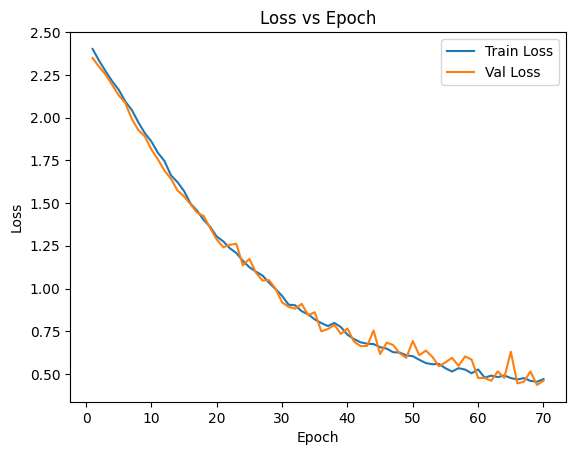

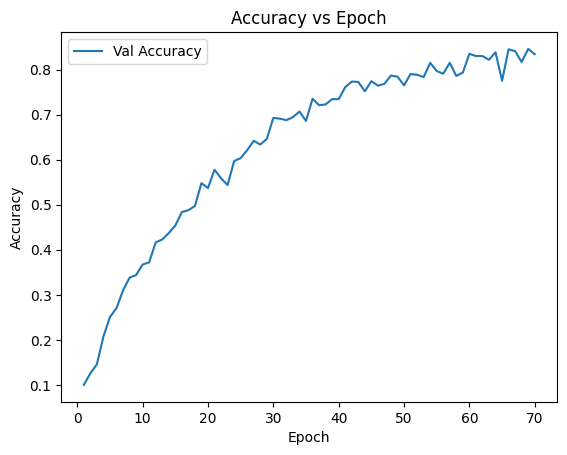

In [14]:
# Loss 曲线
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Loss vs Epoch')
plt.show()

# Accuracy 曲线
plt.figure()
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Accuracy vs Epoch')
plt.show()

/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_64721/3254281880.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/be


=== Classification Report on background Set ===
              precision    recall  f1-score   support

     bananas     1.0000    0.5000    0.6667        20
     bottles     1.0000    0.5000    0.6667        20
       boxes     0.5000    0.5000    0.5000        20
       bread     1.0000    0.5000    0.6667        20
        cans     1.0000    0.5000    0.6667        20
      lemons     1.0000    0.5000    0.6667        20
       pears     1.0000    0.5000    0.6667        20
     peppers     1.0000    0.5000    0.6667        20
    potatoes     0.1702    0.8000    0.2807        20
      yogurt     0.6250    0.5000    0.5556        20

    accuracy                         0.5300       200
   macro avg     0.8295    0.5300    0.6003       200
weighted avg     0.8295    0.5300    0.6003       200



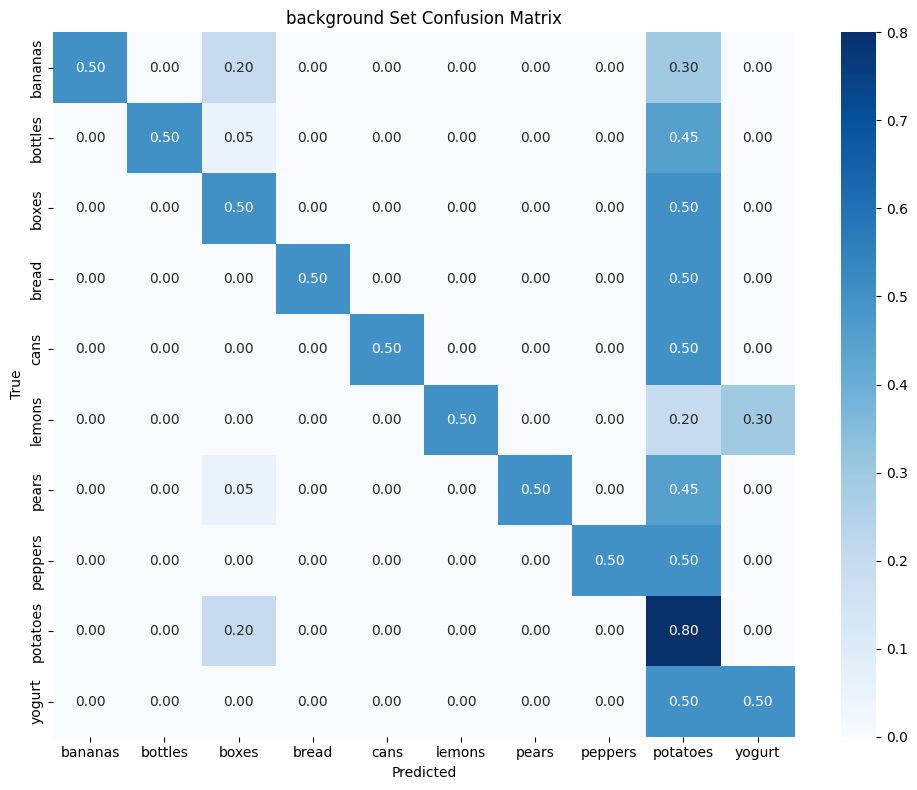


=== Classification Report on categorization Set ===
              precision    recall  f1-score   support

     bananas     0.9590    0.9350    0.9468       200
     bottles     0.5823    0.7250    0.6459       200
       boxes     0.0192    0.0050    0.0079       200
       bread     0.3765    0.1600    0.2246       200
        cans     0.5154    0.6700    0.5826       200
      lemons     0.9302    1.0000    0.9639       200
       pears     0.7500    0.9600    0.8421       200
     peppers     0.9524    1.0000    0.9756       200
    potatoes     0.4983    0.7250    0.5906       200
      yogurt     0.1436    0.1343    0.1388       201

    accuracy                         0.6312      2001
   macro avg     0.5727    0.6314    0.5919      2001
weighted avg     0.5725    0.6312    0.5917      2001



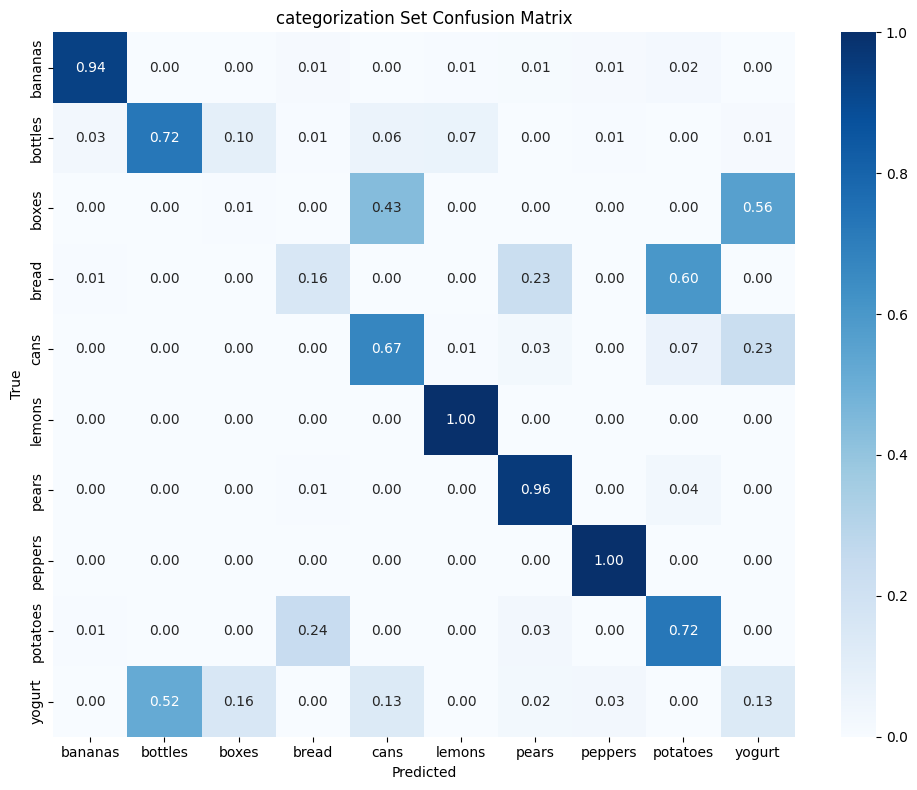


=== Classification Report on demonstrator Set ===
              precision    recall  f1-score   support

     bananas     0.9255    0.8700    0.8969       200
     bottles     0.7249    0.9750    0.8316       200
       boxes     1.0000    0.8850    0.9390       200
       bread     0.3874    0.8600    0.5342       200
        cans     0.5636    0.4650    0.5096       200
      lemons     0.9306    0.6700    0.7791       200
       pears     0.3830    0.2687    0.3158       201
     peppers     0.9263    0.8800    0.9026       200
    potatoes     0.8400    0.7350    0.7840       200
      yogurt     0.6481    0.3500    0.4545       200

    accuracy                         0.6957      2001
   macro avg     0.7329    0.6959    0.6947      2001
weighted avg     0.7328    0.6957    0.6945      2001



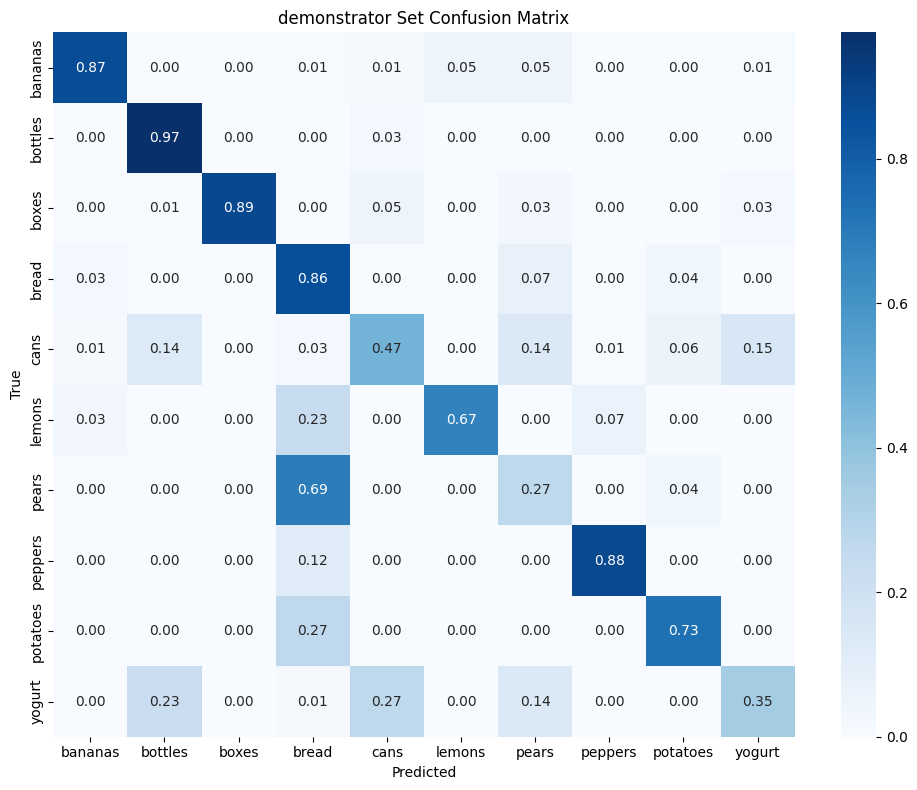


=== Classification Report on robot Set ===
              precision    recall  f1-score   support

     bananas     0.0819    1.0000    0.1515        64
     bottles     0.0000    0.0000    0.0000        76
       boxes     0.0000    0.0000    0.0000        76
       bread     0.0000    0.0000    0.0000        83
        cans     0.1000    0.0267    0.0421        75
      lemons     0.0000    0.0000    0.0000        83
       pears     0.0000    0.0000    0.0000        76
     peppers     1.0000    0.0145    0.0286        69
    potatoes     0.0000    0.0000    0.0000        70
      yogurt     0.0000    0.0000    0.0000       130

    accuracy                         0.0835       802
   macro avg     0.1182    0.1041    0.0222       802
weighted avg     0.1019    0.0835    0.0185       802



/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

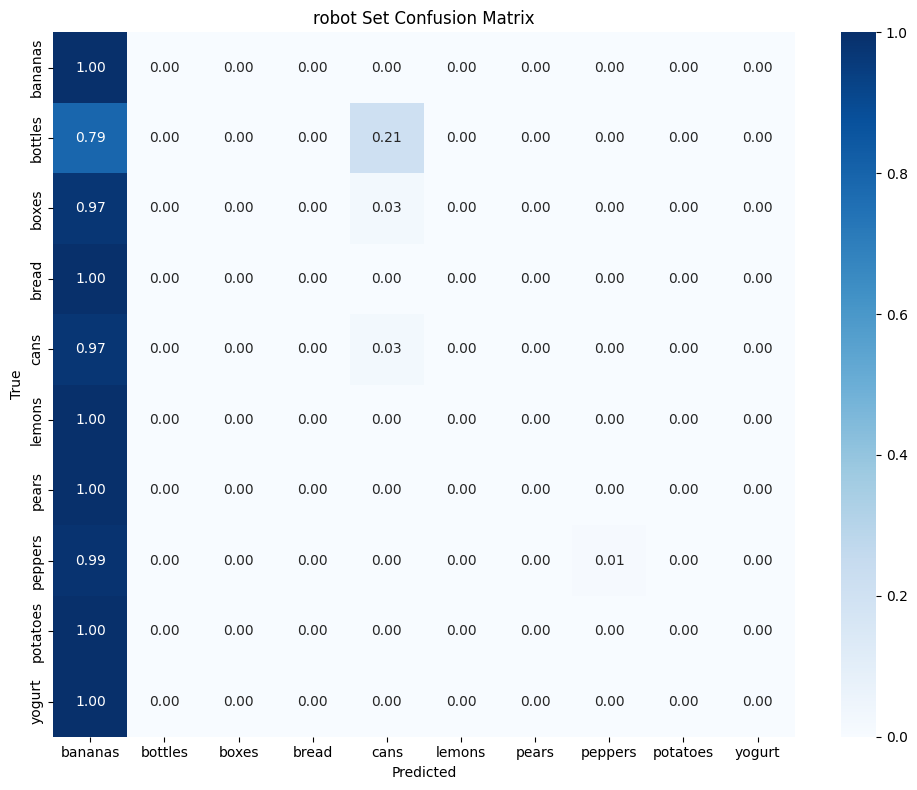

In [15]:
def get_preds_and_targets(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    # 1. 计算 raw CM 并归一化
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # 2. 画图
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 假设 test_loaders 是一个 dict，比如 {'testA': loaderA, 'testB': loaderB}
model.load_state_dict(torch.load('./model/best_model_cnn_icubr.pth'))
for name, loader in test_loaders.items():
    # 取出所有真实 & 预测标签
    y_true, y_pred = get_preds_and_targets(model, device, loader)
    # 拿到 class 名称列表
    # 如果 loader.dataset 是 Subset，就取 subset.dataset.classes
    ds = loader.dataset
    if hasattr(ds, 'dataset'):  # Subset
        classes = ds.dataset.classes
    else:
        classes = ds.classes

    report = classification_report(
                y_true,
                y_pred,
                target_names=classes,
                digits=4   # 控制小数点后几位
            )
    print(f"\n=== Classification Report on {name} Set ===")
    print(report)
    
    # 画图
    plot_confusion_matrix(
        y_true, y_pred, classes,
        normalize=True,
        title=f"{name} Set Confusion Matrix"
    )

In [16]:
# 测试集评估
# test_bg = torchvision.datasets.ImageFolder('data/iCubWorld/test/background', transform_test)
# test_cat = torchvision.datasets.ImageFolder('data/iCubWorld/test/categorization', transform_test)
# test_obj = torchvision.datasets.ImageFolder('data/iCubWorld/test/demonstrator', transform_test)
# test_robot = torchvision.datasets.ImageFolder('data/iCubWorld/test/robot', transform_test)

model.load_state_dict(torch.load('./model/best_model_cnn_icubr.pth'))
# test_loss, test_acc = evaluate(model, device, test_loader, criterion)
# print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc * 100:.2f}%")
for name, loader in test_loaders.items():
    test_loss, test_acc = evaluate(model, device, loader, criterion)
    print(f"\nFinal Test Loss on {name}: {test_loss:.4f} | Final Test Acc on {name}: {test_acc * 100:.2f}%")

/var/folders/y0/5zx_gdxj5rvb7c3v91ml3v780000gn/T/ipykernel_64721/2069221498.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/bes


Final Test Loss on background: 3.2414 | Final Test Acc on background: 53.00%

Final Test Loss on categorization: 1.8846 | Final Test Acc on categorization: 63.12%

Final Test Loss on demonstrator: 1.2249 | Final Test Acc on demonstrator: 69.57%

Final Test Loss on robot: 16.8538 | Final Test Acc on robot: 8.35%
